In [1]:
from sympy import *
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import fsolve
from collections import Counter
from scipy.integrate import odeint
from scipy.linalg import null_space
import time

init_printing() 

In [2]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
def arrange_comp(ccm_comp_len, comp_len):
    var_only = []
    cov_only = []
    sp_only = []
    var_sp = []

    p = 0
    c = ccm_comp_len - comp_len
    for i in range(comp_len):
        for j in range(i,comp_len):
            if j == i:
                var_only.append(p)
                sp_only.append(c)
                var_sp.append(c)
                var_sp.append(p)
                c = c + 1
            else:
                cov_only.append(p)

            p = p + 1    

    return np.array([*var_sp, *cov_only])

In [3]:
def get_stoich_prop(Eqs_to_solve):
    MatEq = expand(Matrix(Eqs_to_solve))
    pseudo_prof = []
    done = set()
    for x in MatEq:
        for y in x.args:
            number = [ atom for atom in y.atoms() if atom.is_number ]
            if number:
                key = y/number[0]
                if key not in done:
                    pseudo_prof.append(key)
                    done.add(key)
            else:
                if y not in done:
                    pseudo_prof.append(y)
                    done.add(y)

    row_len = len(Eqs_to_solve)
    col_len = len(pseudo_prof)

    Sp_stoich = np.zeros((row_len, col_len))
    for i in range(row_len):
        expanded_mat = expand(MatEq[i])
        for j in range(col_len):
            for atom in expanded_mat.args:
                key = atom/pseudo_prof[j]
                if key.is_number:
                    Sp_stoich[i,j] = key
                    break
    return Matrix(Sp_stoich), Matrix(pseudo_prof)

In [4]:
time_ini = time.time()

m     = Symbol('m', positive=True)
P     = Symbol('P', positive=True)
km    = Symbol('km', real = True, constant = True, positive=True)
rm    = Symbol('rm', real = True, constant = True, positive=True)
kp    = Symbol('kp', real = True, constant = True, positive=True)
rp    = Symbol('rp', real = True, constant = True, positive=True)
t  = Symbol('t', real = True, positive=True)

rate_constants = [km, rm, kp, rp]
components = [m, P]

Stoich_mat = Matrix([
    [1, -1,  0,  0], #m
    [0,  0,  1, -1]  #P
])

Prop_vec  = Matrix([
    km,
    m*rm,
    m*kp,
    P*rp,
])   

dX_dt = Stoich_mat*Prop_vec
Aj = dX_dt.jacobian(components)
Prop_vec_F = diag(*Prop_vec )
BBT = Stoich_mat*Prop_vec_F*Stoich_mat.T

comp_len = len(components)
rate_len = len(rate_constants)

################################################################

response_zero_threshold    = 1.0e-10
pseudo_comp_zero_threshold = 1.0e-10
num_sampling = 100
rdigit = 11

################################################################

Cov = Matrix([ 
    [var("C_"+str(components[i])+str(components[j])) for j in range(comp_len)] 
    for i in range(comp_len) 
])

dsub = []
for i in range(comp_len):
    for j in range(i,comp_len):
        Cov[j,i] = Cov[i,j]

dCov_dt = Aj*Cov + Cov*Aj.T + BBT     

Eqs_to_solve = []
ccm_components = []

for i in range(dCov_dt.shape[0]):
    for j in range(i,dCov_dt.shape[0]):
        Eqs_to_solve.append(dCov_dt[i,j].subs(dsub))
        ccm_components.append(Cov[i,j])

for i in range(dX_dt.shape[0]):
    Eqs_to_solve.append(dX_dt[i])
    ccm_components.append(components[i])
    
ccm_comp_len = len(ccm_components)
    

Sp_stoich, fp_Prop = get_stoich_prop(Eqs_to_solve)
fp_Prop = Matrix([ eval(str(x)) for x in fp_Prop ])

kerV = null_space(np.array(Sp_stoich).astype(np.float64))

Ajnew = fp_Prop.jacobian(ccm_components)
Ajnew = Ajnew.col_insert(Ajnew.shape[1],-Matrix(kerV))
Ajnew = lambdify([*ccm_components, *rate_constants], Ajnew)

Jfp_func = lambdify([*ccm_components, *rate_constants],fp_Prop.jacobian(rate_constants).T)
xfunct_ini = lambdify([*ccm_components, *rate_constants], Eqs_to_solve)
xfunct_model = lambda x, y : xfunct_ini(*[*x,*y])

data_fluc = []
index_iter = 0
while index_iter<num_sampling:
    try:
    #if True:
        done_parsing = set()


        kvals = np.random.uniform(80,200,rate_len)  
        ini_cc_val = [ np.random.uniform(0,10) for x in ccm_components ]            
        sol_var = fsolve(xfunct_model, ini_cc_val, args=(kvals), maxfev=1000*len(ini_cc_val))   
        solv_len = len(sol_var)
                
        p = 0
        val_checks = True
        comp_len_dec = comp_len
        while comp_len_dec>0:
            val_checks = val_checks and sol_var[p]>0
            p += comp_len_dec
            comp_len_dec -= 1
            
        for i  in range(1,comp_len+1):
            val_checks = val_checks and sol_var[-i]>0
        
        if val_checks:
            print("iterations =",index_iter+1,end="\r") 
        
            Nans = np.linalg.inv(np.array(Ajnew(*[*sol_var, *kvals]).astype(np.float64)))
            Jfpks = np.array(Jfp_func(*[*sol_var, *kvals]))

            ans = np.zeros((ccm_comp_len, rate_len))
            thr = pseudo_comp_zero_threshold
            for i in range(rate_len):
                col = np.zeros((ccm_comp_len,1))
                for j in range(Jfpks.shape[1]):
                    if Jfpks[i,j] != 0:
                        hold_Nans = np.zeros((ccm_comp_len,1))
                        for hi in range(ccm_comp_len): 
                            
                            if Jfpks[i,j] == 1:
                                hold_Nans[hi] = np.round_(Nans[hi,j]*kvals[i],rdigit)
                            elif abs(Jfpks[i,j]) > thr and abs(sol_var[hi])>thr:
                                hold_Nans[hi] = np.round_(Nans[hi,j]*Jfpks[i,j]*kvals[i],rdigit)
                                                                                    
                        col = col + hold_Nans
                        
                ans[:,i] = col[:,0]

            thr = response_zero_threshold
            for i in range(ans.shape[0]):    
                for j in range(ans.shape[1]):
                                
                    val = ans[i,j]
                    if val>thr:
                        ans[i,j] = 1 
                    elif val<-thr:
                        ans[i,j] = -1 
                    else:
                        ans[i,j] = 0
                            
                    #if ccm_components[i] == ccm_components[9] and rate_constants[j] == k6:
                        #if ans[i,j]<0:
                            #print(ccm_components[i], rate_constants[j], kvals)
                            #print(ccm_components[i], sol_var[9], ccm_components[-1],sol_var[-1])    
                            

            col = []
            for i in range(ans.shape[0]):
                try:
                    col.append("$"+str(ccm_components[i]).replace("_","_{")+"}"+"$")
                except:
                    pass

            label_list = [ "$"+str(x).replace("k","k_{").replace("r","r_{")+"}"+"$" for x in rate_constants ]
            data = np.array(ans[0:len(col),:],dtype=float).T

            data_fluc.append(data)
            index_iter = index_iter + 1
    except:
        pass
    
print(time.time()-time_ini)

0.6231133937835693


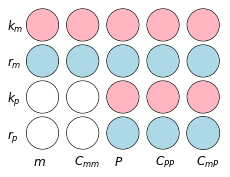

In [7]:
dd = np.array(data_fluc)
order_comp = arrange_comp(ccm_comp_len, comp_len)
dd = dd[:,:,order_comp]

np.save("reg_gene_100.npy", dd, allow_pickle=True)

plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['font.family'] = "DejaVu Sans"

comp_len = len(components)
rate_len = len(rate_constants)

fig = plt.figure(figsize=cm2inch(8, 6))
outer_grid = fig.add_gridspec(rate_len, ccm_comp_len, wspace=0, hspace=0)
ax = outer_grid.subplots()

for i in range(rate_len):
    for j in range(ccm_comp_len):
        cc = plt.Circle((0., 0.), 1.11, color='k',fill=False)
        cc.set_linewidth(1)
        c = Counter(np.round(dd[:,i,j],3))
        sizes = []
        for v in [-1,0,1]:
            if v in c:
                sizes.append(c[v])
            else:
                sizes.append(0)
        #ax[i,j].pie(sizes, autopct='%1.1f%%')
        ax[i,j].add_patch(cc)
        ax[i,j].pie(sizes,startangle=0, radius=1.10,colors=['lightpink', 'white','lightblue'])
        plt.tight_layout()
                
for i in range(rate_len):
    plt.figtext(-0.01,0.212*i+0.15, label_list[rate_len-1-i])
    
for j in range(ccm_comp_len):        
    plt.figtext(0.18*j+0.103,-0.01, col[order_comp[j]])
        
plt.axis('equal')
plt.tight_layout()
plt.savefig("reg_gene_100.png",dpi=600,bbox_inches='tight',transparent=False,pad_inches = 0.01)